#### Instructions:  
1. Libraries allowed: **Python basic libraries, numpy, pandas, scikit-learn (only for data processing), pytorch, and ClearML.**
2. Show all outputs.
3. Submit jupyter notebook and a pdf export of the notebook. Check canvas for detail instructions for the report.
4. Below are the questions/steps that you need to answer. Add as many cells as needed.

## Step 4: hyperparameter tuning without learning rate decay
Do hyperparater tuning with ClearML and copy the plots (e.g., parallel coordinates) from ClearML and visualize them here.

In [ ]:
!pip install --quiet git+https://github.com/allegroai/clearml


In [2]:
pip install --upgrade clearml


Note: you may need to restart the kernel to use updated packages.


Configure ClearML (add credentials as you did in the previous notebook)

In [3]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=ODYR6PYM5NHBOBG1ORU5Q9DY9LTYZH
%env CLEARML_API_SECRET_KEY=JV6KBzwE6Gj7pq7_cZtMUmIwJvkkE8pwlNTDM3RycNXfK_yNOLzjQIQC0h05IHSiHGU

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=ODYR6PYM5NHBOBG1ORU5Q9DY9LTYZH
env: CLEARML_API_SECRET_KEY=JV6KBzwE6Gj7pq7_cZtMUmIwJvkkE8pwlNTDM3RycNXfK_yNOLzjQIQC0h05IHSiHGU


In [5]:
import clearml
clearml.browser_login()

Import libraries and run callback functions

In [8]:
import logging
from clearml import Logger
Logger.set_reporting_nan_value(0.0)

from clearml import Task
from clearml.automation import (
    DiscreteParameterRange, HyperParameterOptimizer, RandomSearch,
    UniformParameterRange, LogUniformParameterRange, UniformIntegerParameterRange)

# trying to load Bayesian optimizer package
try:
    from clearml.automation.optuna import OptimizerOptuna  # noqa
    aSearchStrategy = OptimizerOptuna
except ImportError as ex:
    try:
        from clearml.automation.hpbandster import OptimizerBOHB  # noqa
        aSearchStrategy = OptimizerBOHB
    except ImportError as ex:
        logging.getLogger().warning(
            'Apologies, it seems you do not have \'optuna\' or \'hpbandster\' installed, '
            'we will be using RandomSearch strategy instead')
        aSearchStrategy = RandomSearch


def job_complete_callback(
    job_id,                 # type: str
    objective_value,        # type: float
    objective_iteration,    # type: int
    job_parameters,         # type: dict
    top_performance_job_id  # type: str
):
    print('Job completed!', job_id, objective_value, objective_iteration, job_parameters)
    if job_id == top_performance_job_id:
        print('WOOT WOOT we broke the record! Objective reached {}'.format(objective_value))



Apologies, it seems you do not have 'optuna' or 'hpbandster' installed, we will be using RandomSearch strategy instead


In [12]:
get_task_id = Task.get_task(project_name='Project 1 - YPY', task_name='BASEExperiment').id

In [14]:
get_task_id

'9b3251b5be6e4c37940bd64daca30b3d'

## Initiate a task. 
Note, here you need to provide the ID or project and name of the base task, for which it will change the hyperameterrs.

In [16]:
# Connecting ClearML with the current process,
# from here on everything is logged automatically
task = Task.init(project_name='Hyper-Parameter Optimization',
                 task_name='Automatic Hyper-Parameter Optimization',
                 task_type=Task.TaskTypes.optimizer,
                 reuse_last_task_id=False)

# experiment template to optimize in the hyper-parameter optimization
#
args = {
    'template_task_id': get_task_id,
    'run_as_service': False,
}
args = task.connect(args)

# Get the template task experiment that we want to optimize
if not args['template_task_id']:
    args['template_task_id'] = Task.get_task(
        project_name='Project 1 - YPY', task_name='BASEExperiment').id


ClearML Task: created new task id=7d5c2083835b45628a9606be6065e8f4
ClearML results page: https://app.clear.ml/projects/400027fe36d04fa580b6558a14f81107/experiments/7d5c2083835b45628a9606be6065e8f4/output/log
2024-11-26 19:04:30,168 - clearml.Task - INFO - Storing jupyter notebook directly as code


## Configure the hyperparameters and experiments parameters

In [20]:

# Example use case:
an_optimizer = HyperParameterOptimizer(
    # This is the experiment we want to optimize
    base_task_id=args['template_task_id'],
    # here we define the hyper-parameters to optimize
    # Notice: The parameter name should exactly match what you see in the UI: <section_name>/<parameter>
    # For Example, here we see in the base experiment a section Named: "General"
    # under it a parameter named "batch_size", this becomes "General/batch_size"
    # If you have `argparse` for example, then arguments will appear under the "Args" section,
    # and you should instead pass "Args/batch_size"
    hyper_parameters=[
        # UniformIntegerParameterRange('General/epochs', min_value=5, max_value=10),  # Range for epochs
        UniformIntegerParameterRange('General/fc_units', min_value=4, max_value=12),  # Fully connected units
        LogUniformParameterRange('General/learning_rate', min_value=1.0e-5, max_value=1.0e-3),
        UniformParameterRange('General/momentum', min_value=0.8, max_value=0.9),  # Filters in CNN layers
        UniformIntegerParameterRange('General/num_layers', min_value=2, max_value=3),
    ],
    # this is the objective metric we want to maximize/minimize
    objective_metric_title='Loss',
    objective_metric_series='Training Loss',
    # now we decide if we want to maximize it or minimize it (accuracy we maximize)
    objective_metric_sign='min',
    # let us limit the number of concurrent experiments,
    # this in turn will make sure we do dont bombard the scheduler with experiments.
    # if we have an auto-scaler connected, this, by proxy, will limit the number of machine
    max_number_of_concurrent_tasks=1,
    # this is the optimizer class (actually doing the optimization)
    # Currently, we can choose from GridSearch, RandomSearch or OptimizerBOHB (Bayesian optimization Hyper-Band)
    # more are coming soon...
    optimizer_class=aSearchStrategy,
    # Select an execution queue to schedule the experiments for execution
    # execution_queue=execution_queue,
    # If specified all Tasks created by the HPO process will be created under the `spawned_project` project
    spawn_project=None,  # 'HPO spawn project',
    # If specified only the top K performing Tasks will be kept, the others will be automatically archived
    save_top_k_tasks_only=None,  # 5,
    # Optional: Limit the execution time of a single experiment, in minutes.
    # (this is optional, and if using  OptimizerBOHB, it is ignored)
    #time_limit_per_job=10.,
    # Check the experiments every 12 seconds is way too often, we should probably set it to 5 min,
    # assuming a single experiment is usually hours...
    #pool_period_min=0.2,
    # set the maximum number of jobs to launch for the optimization, default (None) unlimited
    # If OptimizerBOHB is used, it defined the maximum budget in terms of full jobs
    # basically the cumulative number of iterations will not exceed total_max_jobs * max_iteration_per_job
    total_max_jobs=10,
    # set the minimum number of iterations for an experiment, before early stopping.
    # Does not apply for simple strategies such as RandomSearch or GridSearch
    min_iteration_per_job=1,
    # Set the maximum number of iterations for an experiment to execute
    # (This is optional, unless using OptimizerBOHB where this is a must)
    max_iteration_per_job=5,
)

## Peroform tuning

In [ ]:
# if we are running as a service, just enqueue ourselves into the services queue and let it run the optimization
if args['run_as_service']:
    # if this code is executed by `clearml-agent` the function call does nothing.
    # if executed locally, the local process will be terminated, and a remote copy will be executed instead
    task.execute_remotely(queue_name='services', exit_process=True)

# report every 12 seconds, this is way too often, but we are testing here
an_optimizer.set_report_period(0.2)
# start the optimization process, callback function to be called every time an experiment is completed
# this function returns immediately
#an_optimizer.start(job_complete_callback=job_complete_callback)
# You can also use the line below instead to run all the optimizer tasks locally, without using queues or agent
an_optimizer.start_locally(job_complete_callback=job_complete_callback)
# set the time limit for the optimization process (2 hours)
# an_optimizer.set_time_limit(in_minutes=60.0)
# wait until process is done (notice we are controlling the optimization process in the background)
an_optimizer.wait()
# optimization is completed, print the top performing experiments id
top_exp = an_optimizer.get_top_experiments(top_k=3)
print([t.id for t in top_exp])
# make sure background optimization stopped
an_optimizer.stop()

print('We are done, good bye')

In [30]:
task.close()

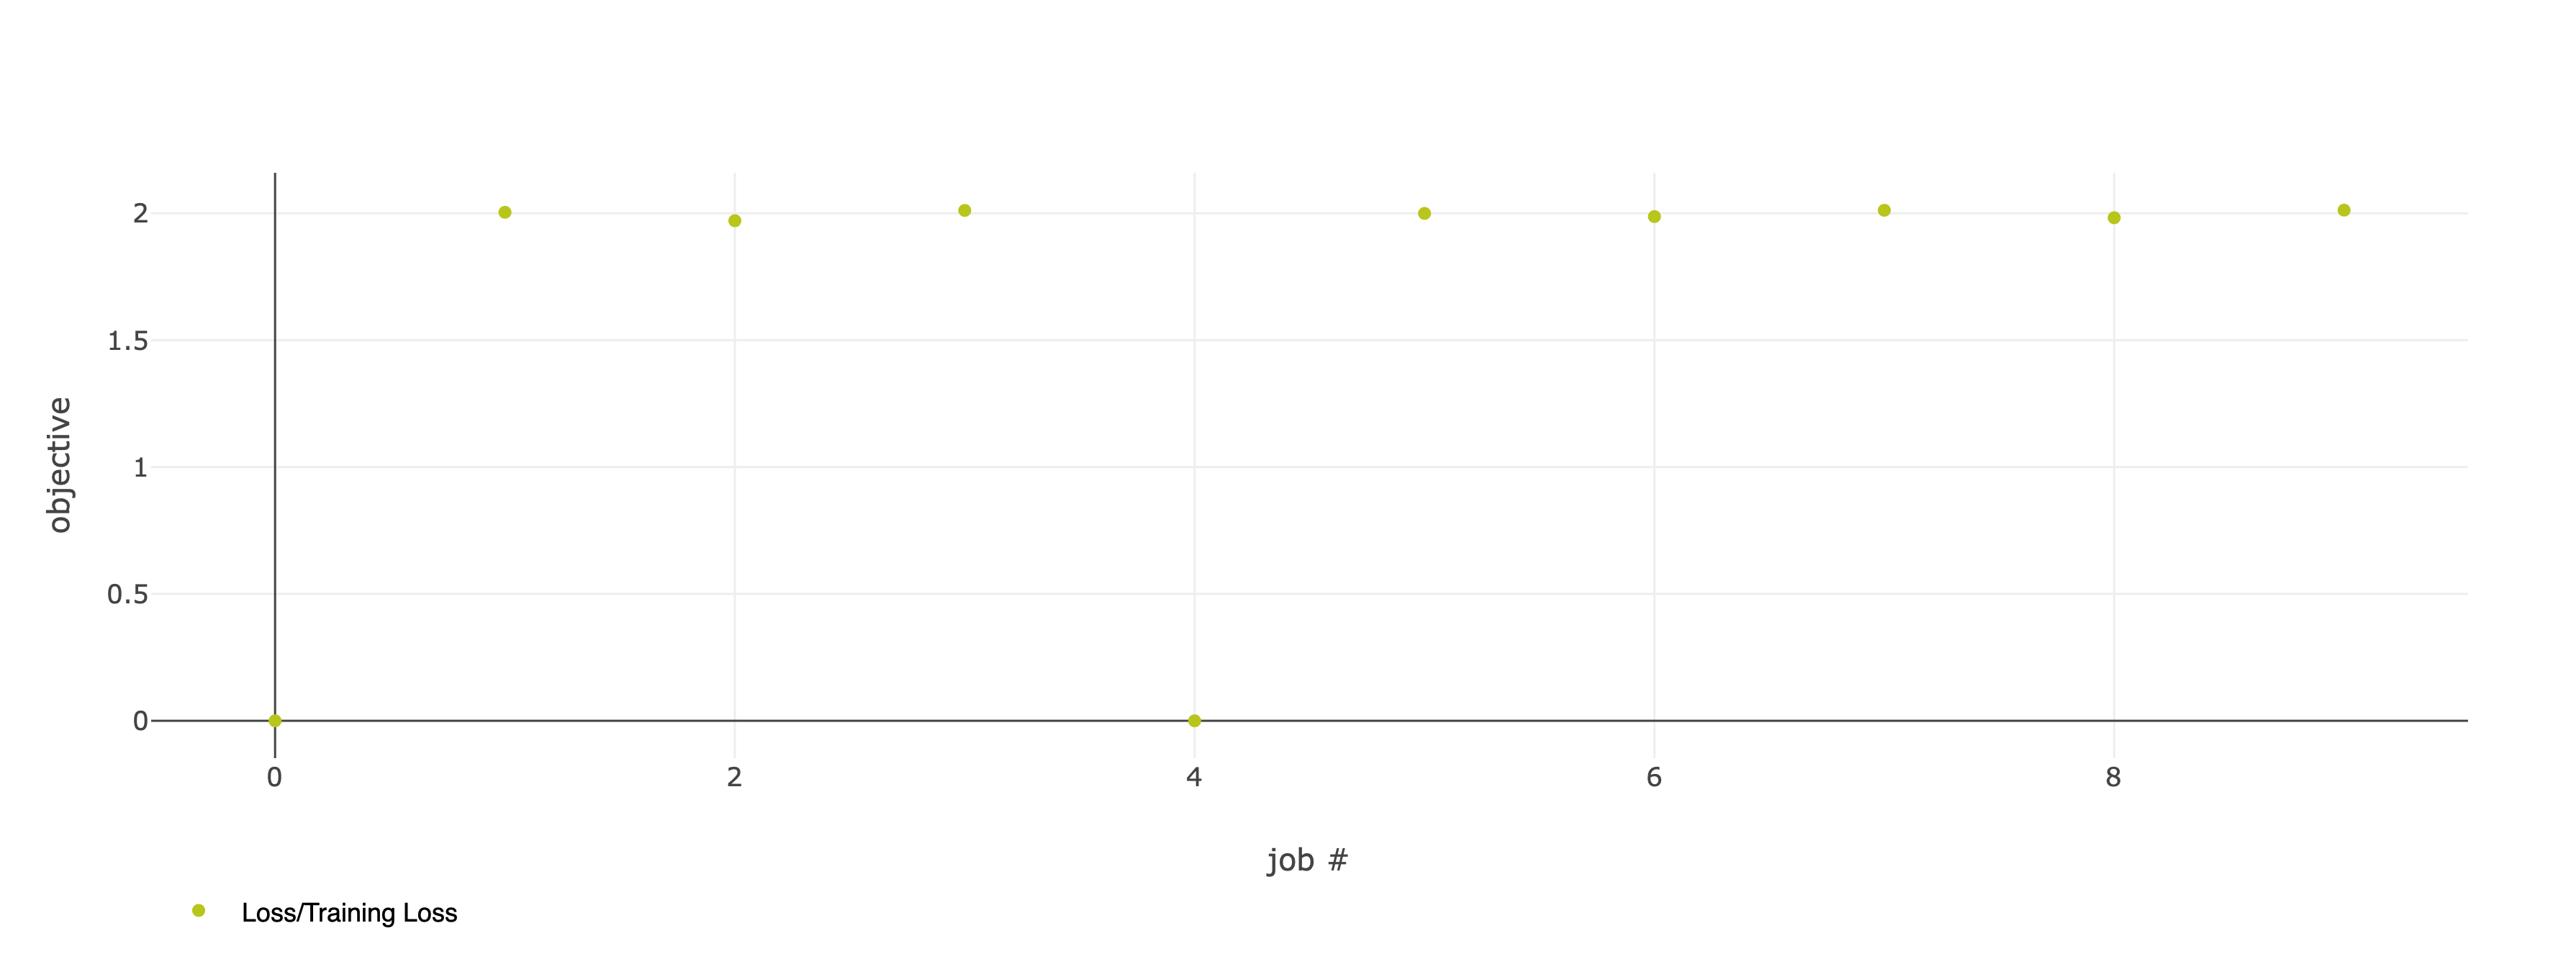

In [22]:
from IPython.display import Image, display


image_path = "./OptimizationObjective.png"
display(Image(filename=image_path))

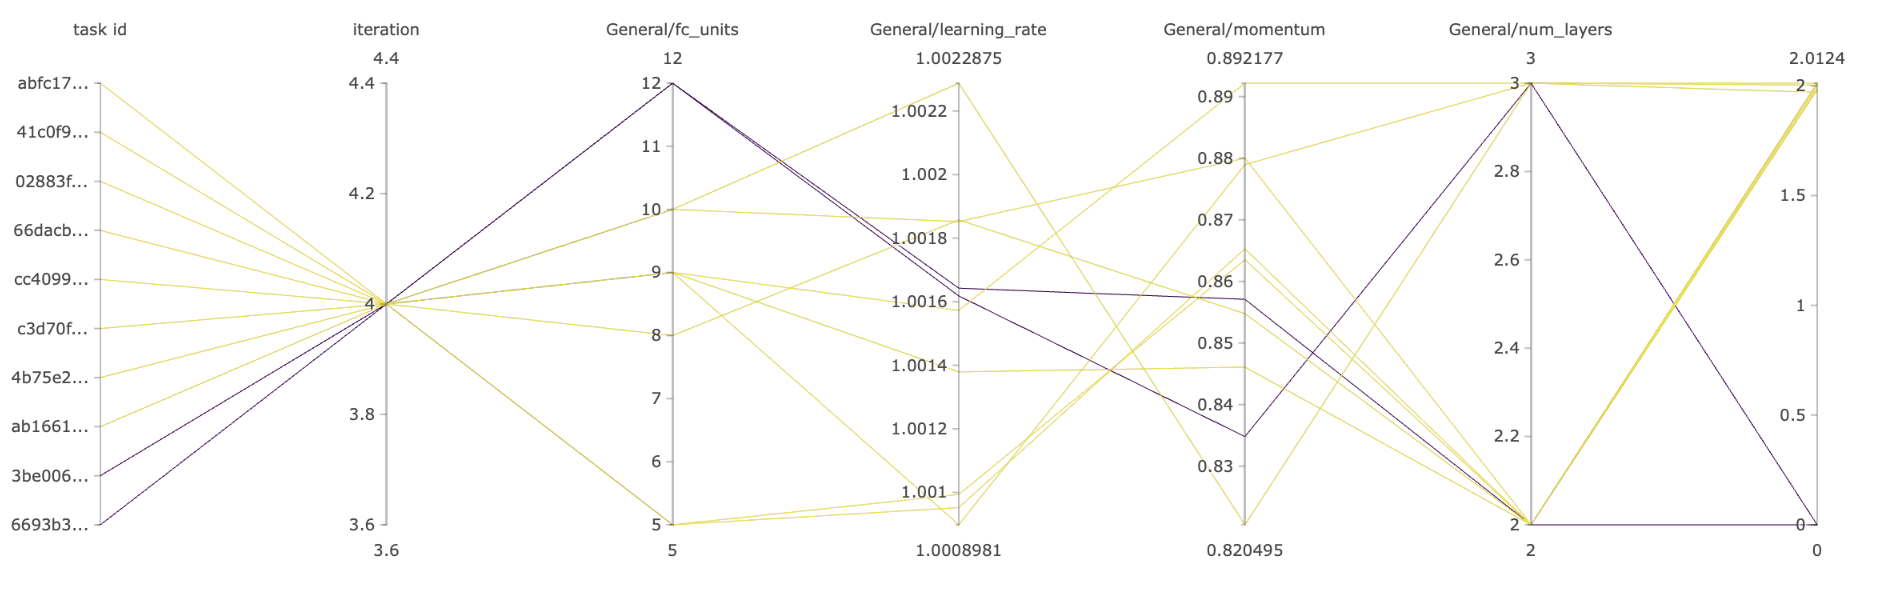

In [24]:
image_path = "./parallel.png"
display(Image(filename=image_path))

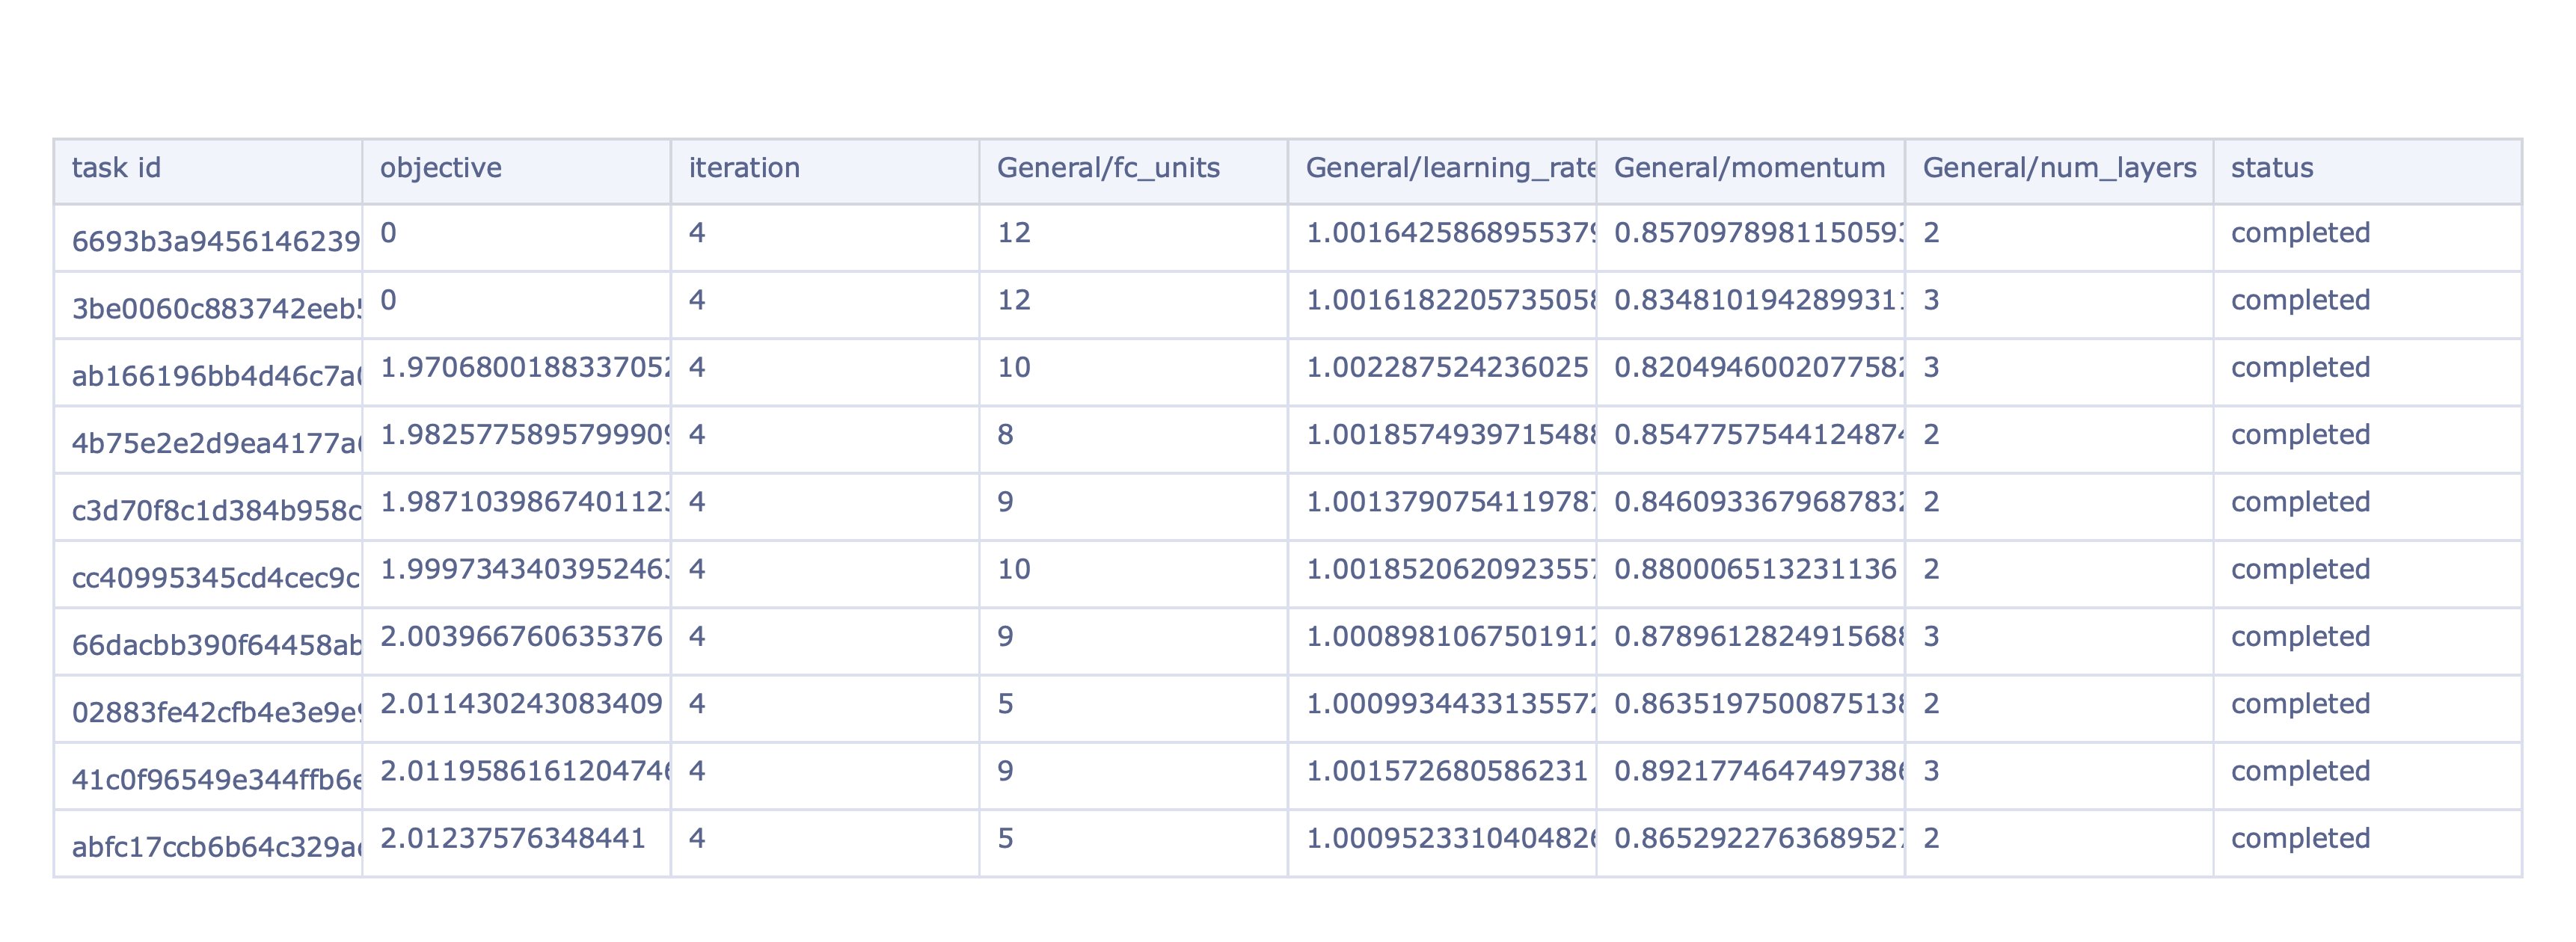

In [28]:
image_path = "./objectiveLossTrainingLoss.png"
display(Image(filename=image_path))

## Step 5: hyperparameter tuning with learning rate decay
Do hyperparater tuning with ClearML and copy the plots (e.g., parallel coordinates) from ClearML and visualize them here.

In [12]:
get_task_id = Task.get_task(project_name='Project 1 - YPY', task_name='BASEExperiment-lr').id
get_task_id

'f43807e747b740c68f2fb7f39e345a04'

In [14]:
# Connecting ClearML with the current process,
# from here on everything is logged automatically
task = Task.init(project_name='Hyper-Parameter Optimization with learning rate decay',
                 task_name='Automatic Hyper-Parameter Optimization',
                 task_type=Task.TaskTypes.optimizer,
                 reuse_last_task_id=False)

# experiment template to optimize in the hyper-parameter optimization
#
args = {
    'template_task_id': get_task_id,
    'run_as_service': False,
}
args = task.connect(args)


# Get the template task experiment that we want to optimize
if not args['template_task_id']:
    args['template_task_id'] = Task.get_task(
        project_name='Project 1 - YPY', task_name='BASEExperiment-lr').id


In [16]:
# Example use case:
an_optimizer = HyperParameterOptimizer(
    # This is the experiment we want to optimize
    base_task_id=args['template_task_id'],
    # here we define the hyper-parameters to optimize
    # Notice: The parameter name should exactly match what you see in the UI: <section_name>/<parameter>
    # For Example, here we see in the base experiment a section Named: "General"
    # under it a parameter named "batch_size", this becomes "General/batch_size"
    # If you have argparse for example, then arguments will appear under the "Args" section,
    # and you should instead pass "Args/batch_size"
    hyper_parameters=[
        UniformIntegerParameterRange('General/fc_units', min_value=4, max_value=12),  # Fully connected units
        LogUniformParameterRange('General/learning_rate', min_value=1.0e-5, max_value=1.0e-3),
        UniformParameterRange('General/momentum', min_value=0.8, max_value=0.9),  # Filters in CNN layers
        UniformIntegerParameterRange('General/num_layers', min_value=2, max_value=3),
        DiscreteParameterRange('General/weight_decay', values=[0.1] ),
        LogUniformParameterRange('General/gamma', min_value=1e-4, max_value=1e-1),
        
    ],
    
    # this is the objective metric we want to maximize/minimize
    objective_metric_title='Loss',
    objective_metric_series='Training Loss',
    # now we decide if we want to maximize it or minimize it (accuracy we maximize)
    objective_metric_sign='min',
    # let us limit the number of concurrent experiments,
    # this in turn will make sure we do dont bombard the scheduler with experiments.
    # if we have an auto-scaler connected, this, by proxy, will limit the number of machine
    max_number_of_concurrent_tasks=2,
    # this is the optimizer class (actually doing the optimization)
    # Currently, we can choose from GridSearch, RandomSearch or OptimizerBOHB (Bayesian optimization Hyper-Band)
    # more are coming soon...
    optimizer_class=aSearchStrategy,
    # Select an execution queue to schedule the experiments for execution
    # execution_queue=execution_queue,
    # If specified all Tasks created by the HPO process will be created under the spawned_project project
    spawn_project=None,  # 'HPO spawn project',
    # If specified only the top K performing Tasks will be kept, the others will be automatically archived
    save_top_k_tasks_only=None,  # 5,
    # Optional: Limit the execution time of a single experiment, in minutes.
    # (this is optional, and if using  OptimizerBOHB, it is ignored)
    #time_limit_per_job=10.,
    # Check the experiments every 12 seconds is way too often, we should probably set it to 5 min,
    # assuming a single experiment is usually hours...
    #pool_period_min=0.2,
    # set the maximum number of jobs to launch for the optimization, default (None) unlimited
    # If OptimizerBOHB is used, it defined the maximum budget in terms of full jobs
    # basically the cumulative number of iterations will not exceed total_max_jobs * max_iteration_per_job
    total_max_jobs=5,
    # set the minimum number of iterations for an experiment, before early stopping.
    # Does not apply for simple strategies such as RandomSearch or GridSearch
    min_iteration_per_job=2,
    # Set the maximum number of iterations for an experiment to execute
    # (This is optional, unless using OptimizerBOHB where this is a must)
    max_iteration_per_job=5,
)

In [18]:
# if we are running as a service, just enqueue ourselves into the services queue and let it run the optimization
if args['run_as_service']:
    # if this code is executed by clearml-agent the function call does nothing.
    # if executed locally, the local process will be terminated, and a remote copy will be executed instead
    task.execute_remotely(queue_name='services', exit_process=True)

# report every 12 seconds, this is way too often, but we are testing here
an_optimizer.set_report_period(0.2)
# start the optimization process, callback function to be called every time an experiment is completed
# this function returns immediately
#an_optimizer.start(job_complete_callback=job_complete_callback)
# You can also use the line below instead to run all the optimizer tasks locally, without using queues or agent
an_optimizer.start_locally(job_complete_callback=job_complete_callback)
# set the time limit for the optimization process (2 hours)
an_optimizer.set_time_limit(in_minutes=60.0)
# wait until process is done (notice we are controlling the optimization process in the background)
an_optimizer.wait()
# optimization is completed, print the top performing experiments id
top_exp = an_optimizer.get_top_experiments(top_k=3)
print([t.id for t in top_exp])
# make sure background optimization stopped
an_optimizer.stop()

print('We are done, good bye')

Progress report #0 completed, sleeping for 0.25 minutes
2024-11-26 22:47:36,528 - clearml.automation.optimization - INFO - Creating new Task: {'General/fc_units': 12, 'General/learning_rate': 1.0016425868955379, 'General/momentum': 0.8570978981150593, 'General/num_layers': 2, 'General/weight_decay': 0.1, 'General/gamma': 1.0925268282695668}
2024-11-26 22:47:39,330 - clearml.automation.optimization - INFO - Creating new Task: {'General/fc_units': 9, 'General/learning_rate': 1.0021264136528782, 'General/momentum': 0.8307633387979503, 'General/num_layers': 2, 'General/weight_decay': 0.1, 'General/gamma': 1.0256942264684388}
Progress report #1 completed, sleeping for 0.2 minutes


2024-11-26 22:47:58.768258: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 22:47:58.935093: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Progress report #2 completed, sleeping for 0.2 minutes


ClearML results page: https://app.clear.ml/projects/0f7abaf167b04b26aab75afa2505db7f/experiments/134ca9fe93e44374a73194cf0eb9ebe9/output/log

TRAIN SET:
  Folder: chichen_itza - 166 images
  Folder: pyramids_of_giza - 166 images
  Folder: roman_colosseum - 166 images
  Folder: taj_mahal - 126 images
  Folder: great_wall_of_china - 166 images
  Folder: machu_pichu - 165 images
  Folder: christ_the_reedemer - 165 images

VALIDATION SET:
  Folder: chichen_itza - 21 images
  Folder: pyramids_of_giza - 21 images
  Folder: roman_colosseum - 21 images
  Folder: taj_mahal - 15 images
  Folder: great_wall_of_china - 21 images
  Folder: machu_pichu - 20 images
  Folder: christ_the_reedemer - 21 images

TEST SET:
  Folder: chichen_itza - 21 images
  Folder: pyramids_of_giza - 21 images
  Folder: roman_colosseum - 21 images
  Folder: taj_mahal - 17 images
  Folder: great_wall_of_china - 20 images
  Folder: machu_pichu - 20 images
  Folder: christ_the_reedemer - 20 images
Custom training set size: 

2024-11-26 23:04:19.367635: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 23:04:19.367644: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ClearML results page: https://app.clear.ml/projects/0f7abaf167b04b26aab75afa2505db7f/experiments/8ecba11d7fa44c9f89c1f0851dbd7fe2/output/log

TRAIN SET:
  Folder: chichen_itza - 166 images
  Folder: pyramids_of_giza - 166 images
  Folder: roman_colosseum - 166 images
  Folder: taj_mahal - 126 images
  Folder: great_wall_of_china - 166 images
  Folder: machu_pichu - 165 images
  Folder: christ_the_reedemer - 165 images

VALIDATION SET:
  Folder: chichen_itza - 21 images
  Folder: pyramids_of_giza - 21 images
  Folder: roman_colosseum - 21 images
  Folder: taj_mahal - 15 images
  Folder: great_wall_of_china - 21 images
  Folder: machu_pichu - 20 images
  Folder: christ_the_reedemer - 21 images

TEST SET:
  Folder: chichen_itza - 21 images
  Folder: pyramids_of_giza - 21 images
  Folder: roman_colosseum - 21 images
  Folder: taj_mahal - 17 images
  Folder: great_wall_of_china - 20 images
  Folder: machu_pichu - 20 images
  Folder: christ_the_reedemer - 20 images
Custom training set size: 

2024-11-26 23:18:20.626620: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-26 23:18:22.568558: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Job completed! d122751c2fef46a89f8889a63594411b [0.0] [4] {'status': 'completed', 'General/fc_units': 10, 'General/learning_rate': 1.0020770717035716, 'General/momentum': 0.8505393033468786, 'General/num_layers': 3, 'General/weight_decay': 0.1, 'General/gamma': 1.0974800167319452}
Job completed! 8ecba11d7fa44c9f89c1f0851dbd7fe2 [0.0] [4] {'status': 'completed', 'General/fc_units': 8, 'General/learning_rate': 1.0015372611275704, 'General/momentum': 0.8832506532618177, 'General/num_layers': 2, 'General/weight_decay': 0.1, 'General/gamma': 1.0585549794308622}


Updating job performance summary plot/table
ClearML results page: https://app.clear.ml/projects/0f7abaf167b04b26aab75afa2505db7f/experiments/3e28324d8f0d47b08a12c45e06c0fa69/output/log

TRAIN SET:
  Folder: chichen_itza - 166 images
  Folder: pyramids_of_giza - 166 images
  Folder: roman_colosseum - 166 images
  Folder: taj_mahal - 126 images
  Folder: great_wall_of_china - 166 images
  Folder: machu_pichu - 165 images
  Folder: christ_the_reedemer - 165 images

VALIDATION SET:
  Folder: chichen_itza - 21 images
  Folder: pyramids_of_giza - 21 images
  Folder: roman_colosseum - 21 images
  Folder: taj_mahal - 15 images
  Folder: great_wall_of_china - 21 images
  Folder: machu_pichu - 20 images
  Folder: christ_the_reedemer - 21 images

TEST SET:
  Folder: chichen_itza - 21 images
  Folder: pyramids_of_giza - 21 images
  Folder: roman_colosseum - 21 images
  Folder: taj_mahal - 17 images
  Folder: great_wall_of_china - 20 images
  Folder: machu_pichu - 20 images
  Folder: christ_the_ree

Progress report #133 completed, sleeping for 0.2 minutes
ClearML results page: https://app.clear.ml/projects/0f7abaf167b04b26aab75afa2505db7f/experiments/3d64d3578c6f444db634bc9cf6a8844e/output/log

TRAIN SET:
  Folder: chichen_itza - 166 images
  Folder: pyramids_of_giza - 166 images
  Folder: roman_colosseum - 166 images
  Folder: taj_mahal - 126 images
  Folder: great_wall_of_china - 166 images
  Folder: machu_pichu - 165 images
  Folder: christ_the_reedemer - 165 images

VALIDATION SET:
  Folder: chichen_itza - 21 images
  Folder: pyramids_of_giza - 21 images
  Folder: roman_colosseum - 21 images
  Folder: taj_mahal - 15 images
  Folder: great_wall_of_china - 21 images
  Folder: machu_pichu - 20 images
  Folder: christ_the_reedemer - 21 images

TEST SET:
  Folder: chichen_itza - 21 images
  Folder: pyramids_of_giza - 21 images
  Folder: roman_colosseum - 21 images
  Folder: taj_mahal - 17 images
  Folder: great_wall_of_china - 20 images
  Folder: machu_pichu - 20 images
  Folder: c

In [20]:
task.close()

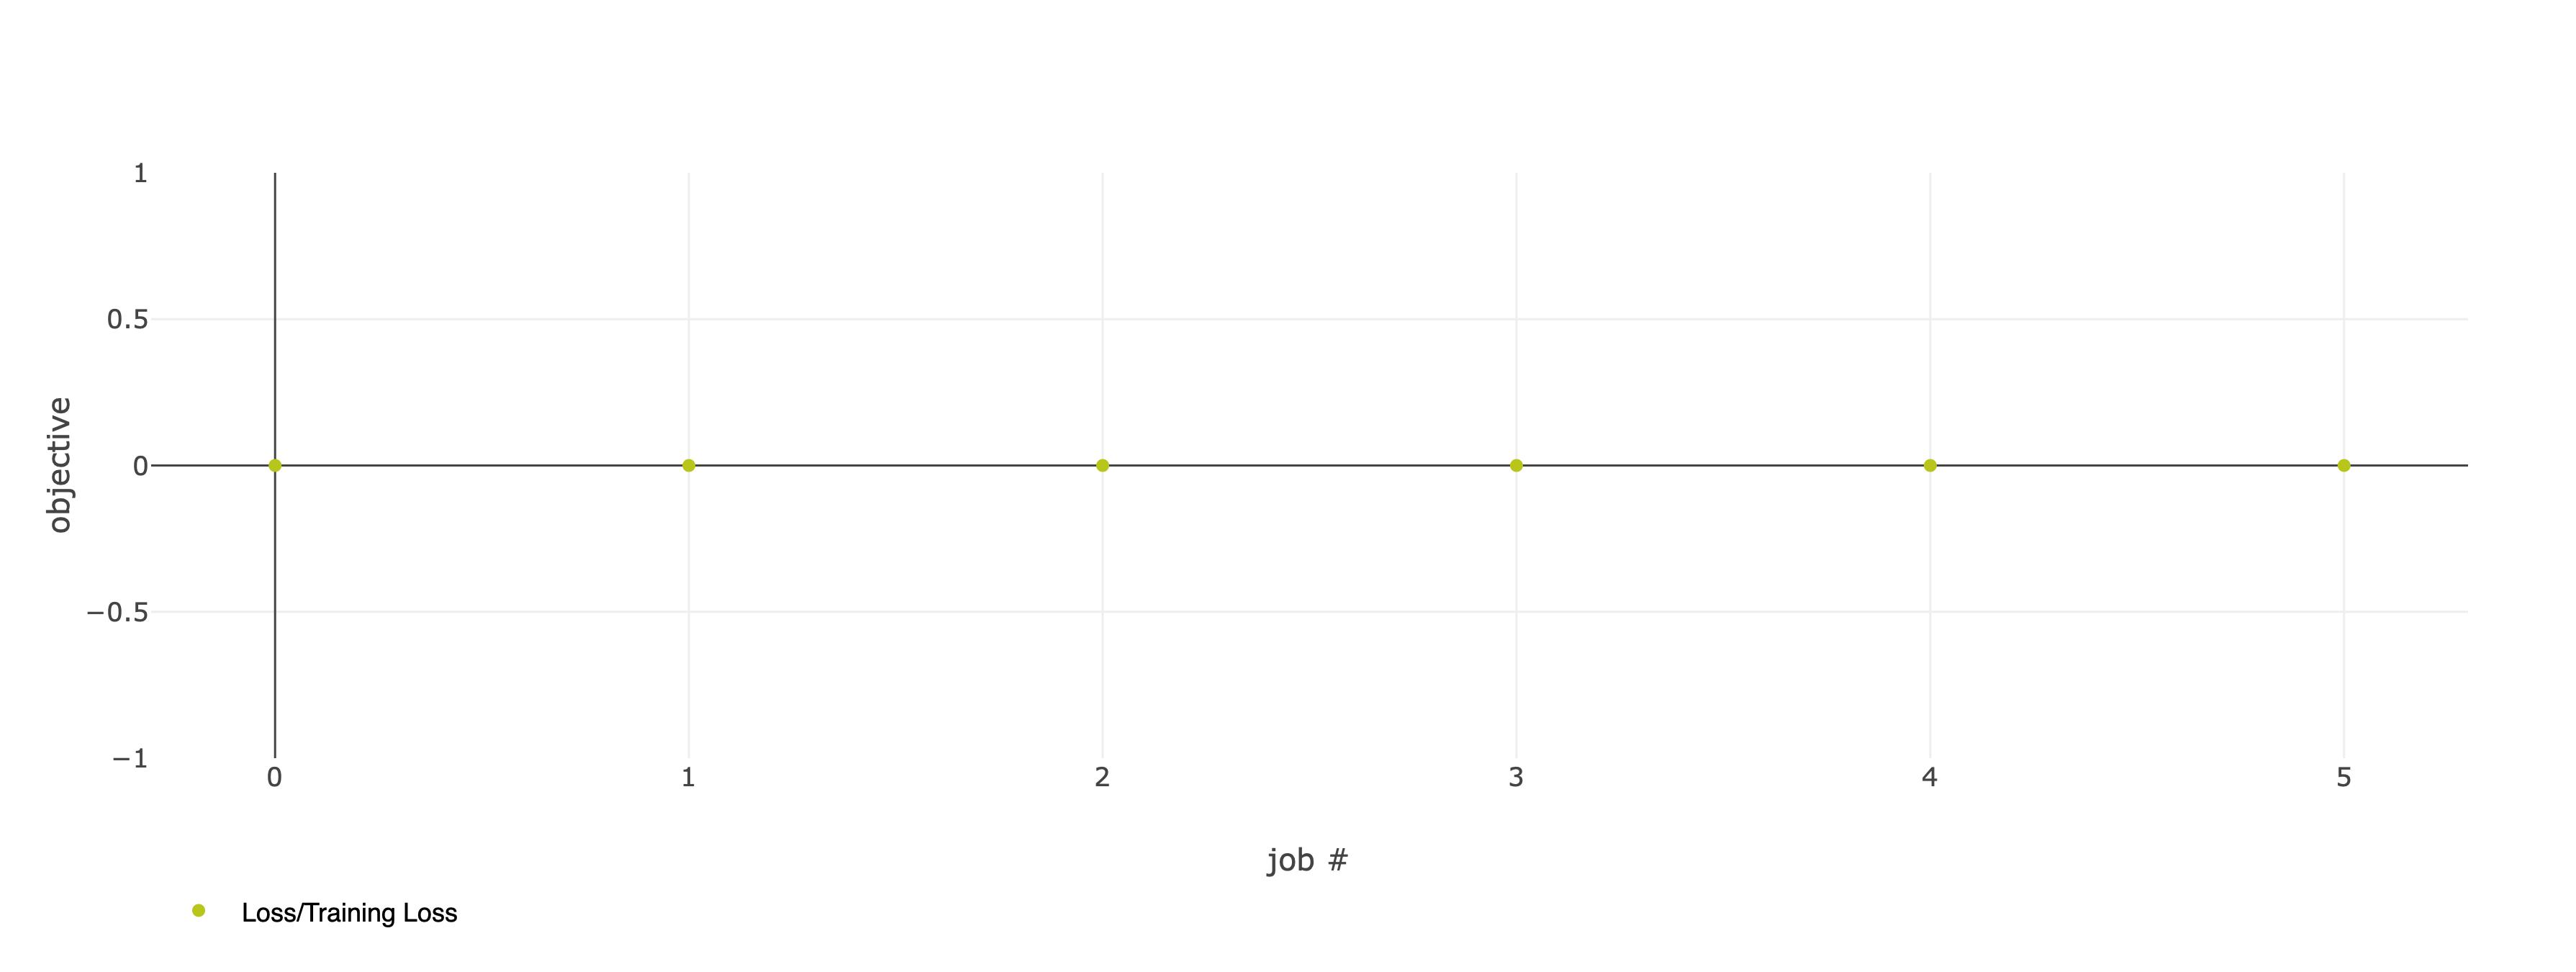

In [32]:
from IPython.display import Image, display


image_path = "./OptimizationObjective-2.png"
display(Image(filename=image_path))

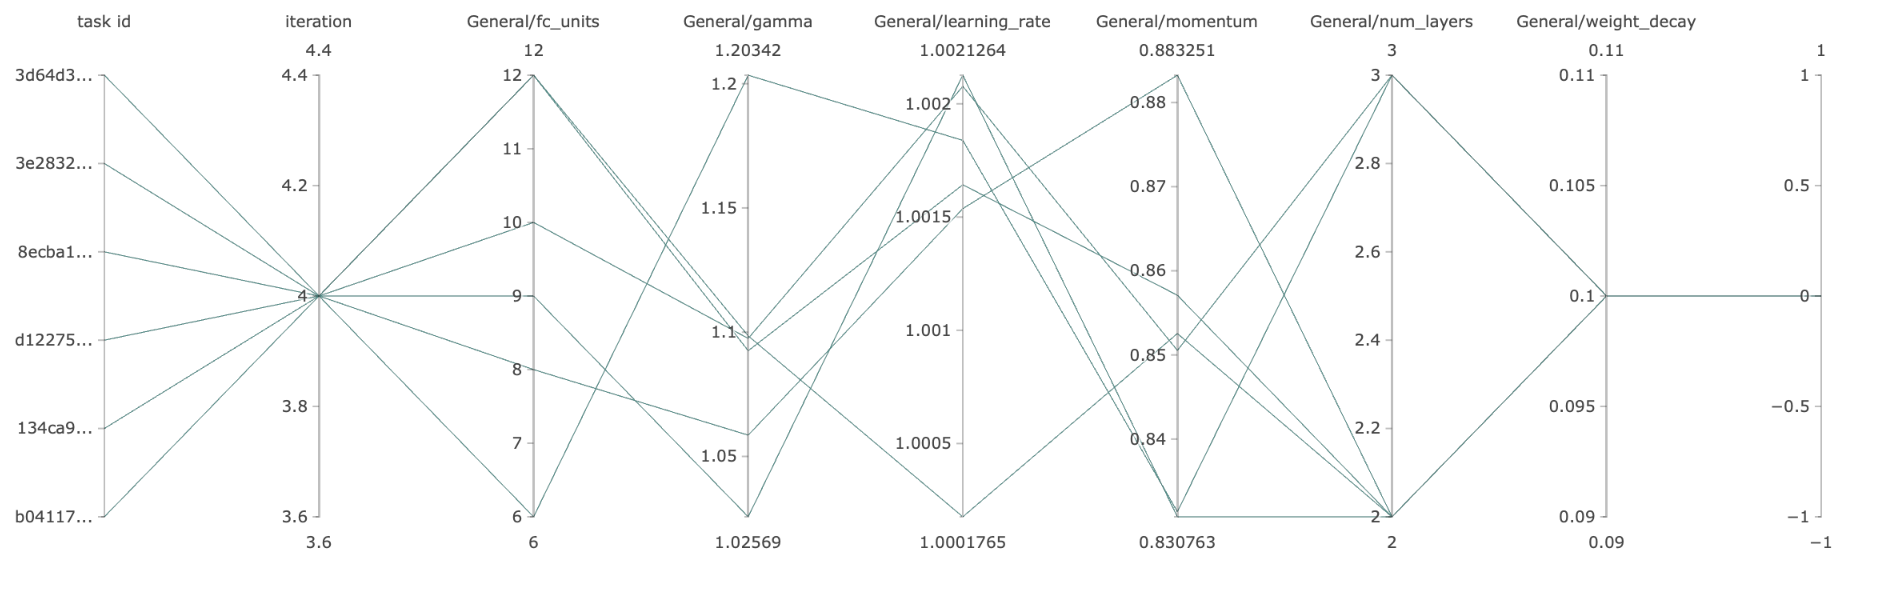

In [30]:
image_path = "./hyperparam.png"
display(Image(filename=image_path))

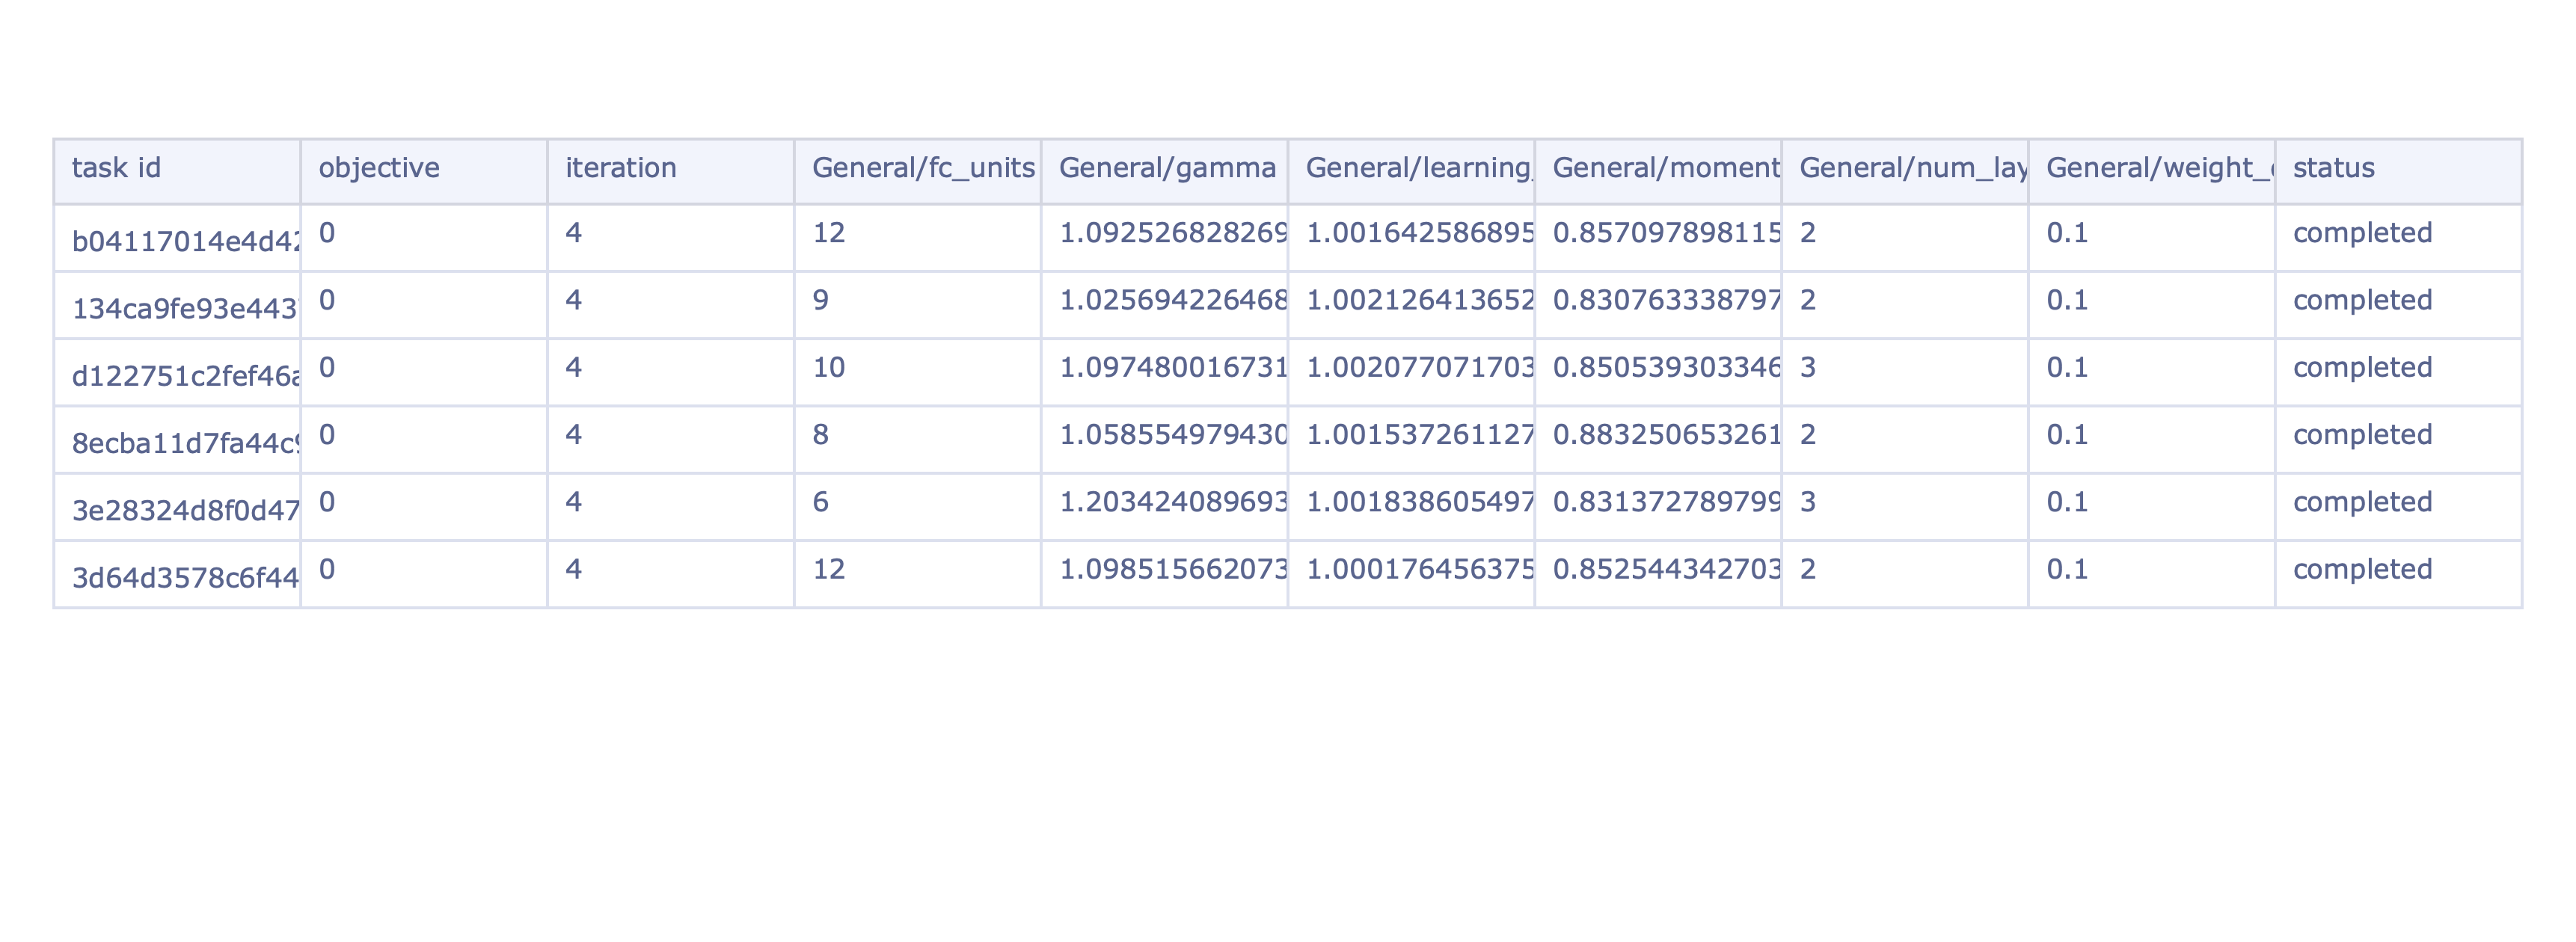

In [36]:
image_path = "./objectiveLossTrainingLoss-2.png"
display(Image(filename=image_path))

## Step 6: Evaluation
Evaluate the best model on test dataset and report accuracy, precision, recall, and F1 score.

In [52]:
import os
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from clearml import Task as task, Logger
import itertools
import random
organized_dir = './organized_ds/organized_dataset'

2024-11-26 23:40:00.235195: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [48]:
# 1 - Partition your dataset into training and test if they are not already. You can do it manually by creating separate folders for training and test.

def list_dataset_structure(base_dir):
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')
    test_dir = os.path.join(base_dir, 'test')

    def list_folders(directory, set_name):
        if not os.path.exists(directory):
            print(f"{set_name} directory not found.")
            return

        print(f"\n{set_name.upper()} SET:")
        categories = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]

        for category in categories:
            category_path = os.path.join(directory, category)
            images = os.listdir(category_path)

            image_count = len([img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"  Folder: {category} - {image_count} images")

    list_folders(train_dir, 'train')
    list_folders(val_dir, 'validation')
    list_folders(test_dir, 'test')

list_dataset_structure(organized_dir)



TRAIN SET:
  Folder: chichen_itza - 166 images
  Folder: pyramids_of_giza - 166 images
  Folder: roman_colosseum - 166 images
  Folder: taj_mahal - 126 images
  Folder: great_wall_of_china - 166 images
  Folder: machu_pichu - 165 images
  Folder: christ_the_reedemer - 165 images

VALIDATION SET:
  Folder: chichen_itza - 21 images
  Folder: pyramids_of_giza - 21 images
  Folder: roman_colosseum - 21 images
  Folder: taj_mahal - 15 images
  Folder: great_wall_of_china - 21 images
  Folder: machu_pichu - 20 images
  Folder: christ_the_reedemer - 21 images

TEST SET:
  Folder: chichen_itza - 21 images
  Folder: pyramids_of_giza - 21 images
  Folder: roman_colosseum - 21 images
  Folder: taj_mahal - 17 images
  Folder: great_wall_of_china - 20 images
  Folder: machu_pichu - 20 images
  Folder: christ_the_reedemer - 20 images


In [54]:
# 3 - Create "transforms" for training and test for normalization and data augmentation.
mean, std = [0.4972, 0.5083, 0.4875],[0.2685, 0.2422, 0.2831]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [56]:
# 4 - Create custom dataset or instantiate built-in "ImageFolder" with the transforms for both training and test.
import os
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

class CustomImageDataset:
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        self.classes = os.listdir(image_dir)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        for cls in self.classes:
            class_dir = os.path.join(image_dir, cls)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label


# Define paths for datasets
train_dir = organized_dir + '/train'
val_dir = organized_dir + '/val'
test_dir = organized_dir + '/test'

# Instantiate datasets
train_dataset = CustomImageDataset(image_dir=train_dir, transform=train_transforms)
val_dataset = CustomImageDataset(image_dir=val_dir, transform=train_transforms)
test_dataset = CustomImageDataset(image_dir=test_dir, transform=test_transforms)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check dataset sizes
print(f"Custom training set size: {len(train_dataset)}")
print(f"Custom validation set size: {len(val_dataset)}")
print(f"Custom test set size: {len(test_dataset)}")

Custom training set size: 1120
Custom validation set size: 140
Custom test set size: 140


In [62]:
params = {
    "num_layers": 3,
    "num_filters": 24,
    "fc_units": 10,
    "learning_rate":1.002287524236025,
    "momentum": 0.8204946002077582,
    "weight_decay": 0.0005,
    "epochs": 5,
}


In [82]:
# Step 1: Build CNN class
class CNN(nn.Module):
    def __init__(self, num_layers, num_filters, num_classes, fc_units):
        super(CNN, self).__init__()
        self.convs = nn.ModuleList()
        in_channels = 3

        for _ in range(num_layers):
            self.convs.append(nn.Conv2d(in_channels, num_filters, kernel_size=3, padding=1))
            self.convs.append(nn.ReLU())
            self.convs.append(nn.MaxPool2d(2, 2))
            in_channels = num_filters

        conv_output_size = (224 // (2 ** num_layers))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_filters * conv_output_size * conv_output_size, fc_units),
            nn.ReLU(),
            nn.Linear(fc_units, num_classes)
        )

    def forward(self, x):
        for layer in self.convs:
            x = layer(x)
        x = self.fc(x)
        return x
        
model = CNN(num_layers=params["num_layers"],
                   num_filters=params["num_filters"],
                   num_classes=len(train_dataset.classes),
                   fc_units=params["fc_units"])

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=params["learning_rate"],
                      momentum=params["momentum"],
                      weight_decay=params["weight_decay"])

In [68]:

def train(model, loader, optimizer, loss_function, epochs):
    model.train()
    train_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(loader))
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]:.6f}")

    return train_losses


In [84]:
train_losses = train(model, train_loader, optimizer, loss_function, epochs=params['epochs'])

Epoch 1/5, Training Loss: 2.406899
Epoch 2/5, Training Loss: 1.976770


KeyboardInterrupt: 

## Step 7: Analysis
Provide a complete analysis of the whole process.

In [90]:
model.eval() 
all_preds = []
all_labels = []
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Evaluate the model on the test data
with torch.no_grad():
    for images, labels in test_loader: 
        images, labels = images, labels
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average="weighted")
recall = recall_score(all_labels, all_preds, average="weighted")
f1 = f1_score(all_labels, all_preds, average="weighted")

# Print the metrics
print("Evaluation Metrics on Test Data:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Evaluation Metrics on Test Data:
Accuracy: 0.1500
Precision: 0.0225
Recall: 0.1500
F1 Score: 0.0391


/Users/yashnayi/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

